# Deep Neural Network

## **0. Introduction**

This notebook continues the series of machine learning techniques with the goal to decode the brain activitiy given the respective categories. Unfortunately, neither the LogReg nor the SVM produced any results that back the initial hypothesis. Still, we will set up the Neural network for the purpose of learning the respective technique.

For this notebook, we will work with the z-maps `per run`.

## **1.0 Loading the data**

In [1]:
import os
os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")

In [2]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')

In [3]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
X = []
y = []
Sessions = []
category = 1
cat_index = 0
cat_index_boundary = 5

for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}_perrun'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            y.append(category)
            Sessions.append(session)
            cat_index = cat_index + 1
            if cat_index == cat_index_boundary:
                category=category+1
                cat_index_boundary = cat_index_boundary+5
            if category == 27:
                category = 1

y = np.array(y)
df =  pd.DataFrame(np.concatenate(X))
X = df.to_numpy()

Rescaling, because PyTorch requires Y labels to range from 0 to 1.

In [5]:
y = y-1
y

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 19

Splitting dataset into training set and test set

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

## **2.0 Setting up the neural network**

General imports of pytorch modules needed to define the network. NN stands for Neural Network and is part of the pytorch library.

In [9]:
import torch
from torch import nn
from torch import optim

Pytorch works with `tensors`. Thus, our usual numpy arrays need to be converted to pytorch tensors.

Specifically, the X tensors must be in the datatype `float32` and the y tensors in the datatype `LongTensor`.

In [10]:
X_tensor_train = torch.from_numpy(X_train)
Y_tensor_train = torch.from_numpy(y_train)
X_tensor_test = torch.from_numpy(X_test)
Y_tensor_test = torch.from_numpy(y_test)

Converting to tensors and now transforming them into the aforementioned datatype.

In [11]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
Y_tensor_train = Y_tensor_train.type(torch.LongTensor)

X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
Y_tensor_test = Y_tensor_test.type(torch.LongTensor)

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Now that we took care of that, we should define our neural network by using pythons *classes* and the pytorch nn.Module. Then, we initialize and determine the inputs: The class takes three arguments: `Itself` (so the nn.Module), `n_inputs` and `n_outputs`, corresponding to our usual X and y data. 
We apply the super function in order to invoke the properties of the class.

Then we define our first variables: "self.in_layer" and "self.out_layer".
By using the linear function of the nn module we define for the first variable, that it takes n inputs and n hidden layers. This is our input layer, so the information is forwarded from the n_input to n_hidden layers. The out_layer variable passes the input from the n_hidden layers to 26 output layers. 26 is chosen, because we want to predict 26 classes.

We are also adding a dropout layer. This helps us with the `regularization` process. Dropout in general is described as

"Dropout is a machine learning technique where you remove (or "drop out") units in a neural net to simulate training large numbers of architectures simultaneously. Importantly, dropout can drastically reduce the chance of overfitting during training." [SOURCE](https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE)

We go on by defining the forward method. The forward method runs when calling the class as a function. It takes the z_maps as an input and passes it through the hidden layer to produce the weights and to finally pass it to the output layer, in order to predict the respective category.

I definitely got a lot of help for this by following the Neuromatch course on [computational neuroscience](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial1.ipynb#scrollTo=JFdPAcDx22RZ).

In [12]:
class DecodingReLuNN(nn.Module):
    def __init__(self,n_inputs,n_hidden):
        super().__init__()
        self.in_layer = nn.Linear(n_inputs,n_hidden)
        self.dropout = nn.Dropout(0.25)
        self.out_layer = nn.Linear(n_hidden, 26)
    def forward(self,V_P):
    #Decode category from voxel pattern

    #Args:
     # Voxel_pattern (torch.Tensor): vector of neural responses to decode, must be of
      #  length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
       # containing n_stimuli vectors of neural responses

    #Returns:
    #torch.Tensor: network outputs for each input provided in Voxel_pattern. If
    #Voxel_pattern is a vector, then y is a 1D tensor of length 1. If Voxel_pattern is a 2D
    #tensor then y is a 2D tensor of shape n_stimuli x 1.
    
        V_P = torch.relu(self.in_layer(V_P))
        V_P = self.dropout(V_P)
        V_P = self.out_layer(V_P)
        return V_P

We now set up a loss function. A very common loss function for multiclass problems is the CrossEntropyLoss. We set the loss function and run our deep neural network very naively on our training and testing set.

In [13]:
np.random.seed(1)
torch.manual_seed(1)

#Initialize a deep network with 10 hidden units
net = DecodingReLuNN(X_tensor_train.shape[1], 30)

# Get voxel pattern and predicted category for all stimuli
V_P, category = X_tensor_train, Y_tensor_train 

# Decode category from these neural responses using initialized network
out = net(V_P)  # compute output from network, equivalent to net.forward(r)
loss_fn = nn.CrossEntropyLoss()

# Evaluate Cross entropy loss
loss = loss_fn(out, category)
y_pred_probs = torch.softmax(out, dim=1) #get probability for given class
y_preds = y_pred_probs.argmax(dim=1)
print('true category: {}'.format(category))
print('Predicted category:{}'.format(y_preds))
print('cross entropy loss {}'.format(loss))

true category: tensor([ 8,  9, 15, 14, 18, 22, 12, 10, 21, 19, 12, 13, 15, 20, 12, 23, 17,  8,
        15, 13,  3,  6, 10, 16,  3,  1, 11, 22, 16, 10,  2,  5,  0,  8, 23,  2,
        15,  5, 25,  4,  6, 22, 20,  6,  4, 11, 16,  4,  3, 23, 13, 19, 19, 18,
        14,  4,  4, 22,  6, 23,  1, 23,  9,  3,  3, 18, 22,  0,  2,  7, 12, 22,
        13,  2,  5,  4,  4,  5,  1, 10, 16, 21,  7,  5, 19, 23, 22,  7,  9, 14,
        21,  2, 12, 24,  1, 23, 19, 21, 14,  2,  3, 13, 20,  7, 11, 21,  0, 10,
        12, 16, 21,  0,  3, 18,  4, 18,  4,  3, 16, 20,  7,  6, 13, 24, 14, 15,
        20, 21, 23,  6,  8, 13, 21,  5, 23,  1,  1, 10,  1, 24,  7, 13,  1, 25,
         9,  8,  5, 11, 15, 23, 22, 17, 14,  1, 22,  4,  1,  7, 13, 13,  8,  3,
         3,  3, 11,  7, 24, 24, 19,  2, 21, 12, 19, 16, 24, 10, 14, 23, 11, 22,
        20, 10,  4, 21, 25, 19, 18, 25, 17, 25,  9,  7, 12,  0,  2, 21,  8,  6,
        24, 18, 22,  9, 11,  6, 16, 22, 22, 20, 24, 12,  6,  1, 13, 25, 20, 23,
        24, 20, 18, 10, 1

We see that the loss is quite high and not really anything could be predicted. This becomes apparent if we compare the labels from the `true category` with the labels from the `predicted category`.

Now we set up the analysis loop. This analysis loop comes with some more hyperparameters. The amount of epochs, the learning rate and the weight decay.

The `epoch` is defined as one whole pass through the data. It is common that a neural network is trained on the data for several epochs.

`The learning rate` is tightly related to the **backpropagation**, which is the algorithm that ensure that the network is learning (=adapting the weights accordingly). The learning rate defines how "fast" (at which rate) this learning takes place.

**Note**: The whole process of how an algorithm learns is a complex one and cannot be explained in this notebook. If you are interested in how everything takes place, you might want to watch this youtube video (or consult anyother resources). Like the amazing course on computational neuroscience and Deep Learning from the Neuromatch academy, which was linked above.

[![Video](https://img.youtube.com/vi/v=IHZwWFHWa-w&t=5s/0.jpg)](https://www.youtube.com/watch?v=IHZwWFHWa-w&t=5s)

We choose the stochastic gradient descent as our optimizer and also introduce a weight_decay.
Weight decay is a `regularization technique` that should prevent overly complex models and thus overfitting.

In [14]:
def analysis(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=0.01):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_loss = []
    net.train()
    for i in range(n_epochs):
        out = net(train_data)  # compute network output from inputs in train_data
        
        # Clear previous gradients
        optimizer.zero_grad()
        # evaluate loss function
        loss = loss_fn(out, train_labels)
        # Compute gradients
        loss.backward() 
        # Update weights
        optimizer.step()
        # Store current value of loss
        train_loss.append(loss.item()) # .item() needed to transform the tensor output of loss_fn to a scalar
        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
          print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
    y_pred = torch.softmax(out,dim=1).argmax(dim=1)
    
    ##evaluating model
    with torch.no_grad():
        net.eval()
        inputs,labels = X_tensor_test, Y_tensor_test
        outputs = net(inputs)
        test_loss = loss_fn(outputs,labels)
    y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)
    return train_loss, y_pred, y_pred_test, test_loss

We can now run this loop on our data, and plot the cross entropy loss per epoch.

Amount of hidden neurons per layer are set to 509, because it follows the equation n_neurons = input_layer+output_layer/2.

The epoch is set to 1000 and the learning rate to 0.1.

iteration 200/1000 | loss: 0.683
iteration 400/1000 | loss: 0.113
iteration 600/1000 | loss: 0.056
iteration 800/1000 | loss: 0.031
iteration 1000/1000 | loss: 0.024


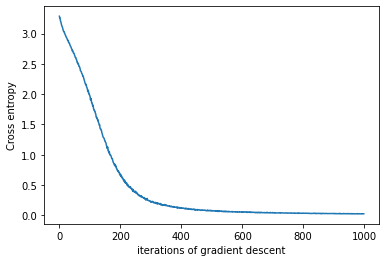

In [25]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

    # Initialize network with 509 hidden neurons
net = DecodingReLuNN(X_tensor_train.shape[1], 509) #509 = input layer + output / 2

    # Initialize built-in PyTorch Crossentrop loss function
loss_fn = nn.CrossEntropyLoss()

    # Run gradient descent on data
train_loss,y_pred,y_pred_test,test_loss = analysis(net,loss_fn,X_tensor_train,Y_tensor_train,
                                      n_epochs = 1000,learning_rate=0.1)
  

    # Plot the training loss over iterations of GD
    
plt.plot(train_loss)

plt.xlabel('iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.show()

It becomes apparent, that with the chosen hyperparameters the loss slowly minimizes over the epochs.
Lets visualise our results with our good ol friend, the confusion matrix.

[Text(0.5, 1.0, 'Confusion matrix for the training set')]

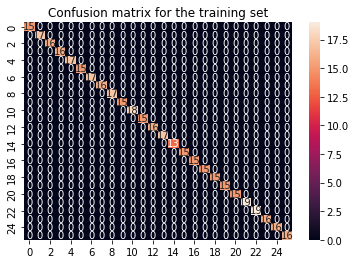

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_train = confusion_matrix(Y_tensor_train, y_pred)

sns.heatmap(cf_matrix_train, annot = True).set(title='Confusion matrix for the training set')

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_tensor_train,y_pred)

1.0

[Text(0.5, 1.0, 'Confusion matrix for the test set')]

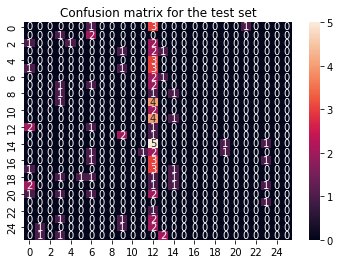

In [27]:
cf_matrix_test = confusion_matrix(Y_tensor_test, y_pred_test)

sns.heatmap(cf_matrix_test, annot = True).set(title='Confusion matrix for the test set')

In [19]:
accuracy_score(Y_tensor_test,y_pred_test)

0.009615384615384616

And with those wonderful results we come to an end of our machine learning journey.

The results can be summarized fairly easy: The fully connected neural network did not change anything regarding the outcome the classification task.


Further implications are discussed in the discussion section.